In [ ]:
# Kiley Huffman
# QBIO 465
# Assignment 6
# Due: Weds, March 27

In [2]:
# !pip install spektral // Commented out after installation

In [4]:
# !pip install scikit-learn // had to use newer version of scikit, 1.1.3 was not working for me

# Q1: Exploring and Visualizing the PROTEINS Dataset
1. Dataset Inspection & Statistics
   
    a. Load the PROTEINS dataset using the provided code from the lecture.
   
    b. Print the total number of graphs, the number of node features per graph, and the number of classes.

In [7]:
# I was having issues with spektral, so I had to use torch to get the TUDataset
import torch
from torch_geometric.datasets import TUDataset

# Load the PROTEINS dataset
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

# Total number of graphs in the dataset
num_graphs = len(dataset)

# Number of node features per graph
num_node_features = dataset.num_node_features

# Number of classes in the dataset
num_classes = dataset.num_classes

# Print info
print(f"The total number of graphs: {num_graphs}")
print(f"The number of node features per graph: {num_node_features}")
print(f"The number of classes: {num_classes}")

The total number of graphs: 1113
The number of node features per graph: 3
The number of classes: 2


2. Computing Graph Statistics

a. Iterate over all graphs in the dataset to compute: the number of nodes per graph, the number of edges per graph (remember that for  undirected graphs each edge is counted twice). and the global label for each graph (convert from a one-hot vector to an integer).

b. Store these statistics as NumPy arrays.

In [9]:
# Extract info
import numpy as np
num_nodes_array = np.array([data.num_nodes for data in dataset])
num_edges_array = np.array([data.num_edges // 2 for data in dataset])  # Avoid double-counting (each edge is counted twice)
labels_array = np.array([data.y.item() for data in dataset])  # Convert to integer labels from one-hot vector

# Print info
print(f"The number of nodes per graph: {num_nodes_array[:5]}")
print(f"The number of edges per graph: {num_edges_array[:5]}")
print(f"The global label for each graph: {labels_array[:5]}")


The number of nodes per graph: [42 27 10 24 11]
The number of edges per graph: [81 46 17 46 21]
The global label for each graph: [0 0 0 0 0]


3. Visualization
   
a. Plot a histogram of the number of nodes per graph.

b. Plot a histogram of the number of edges per graph.

c. Create a bar plot to show the distribution of graph labels.

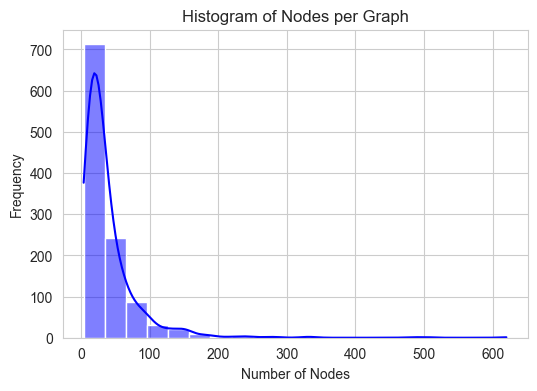

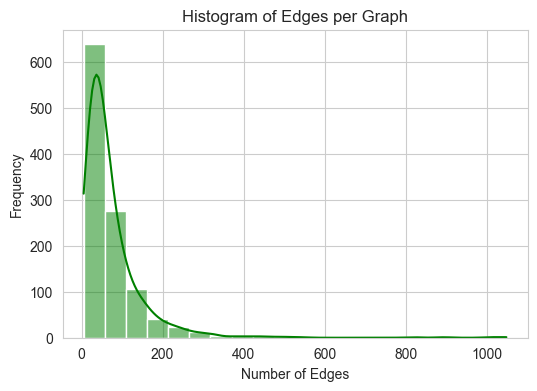

/var/folders/_g/_psh8dpd7bl2197ft_38stfh0000gn/T/ipykernel_29173/2012741180.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels_array, palette="viridis")


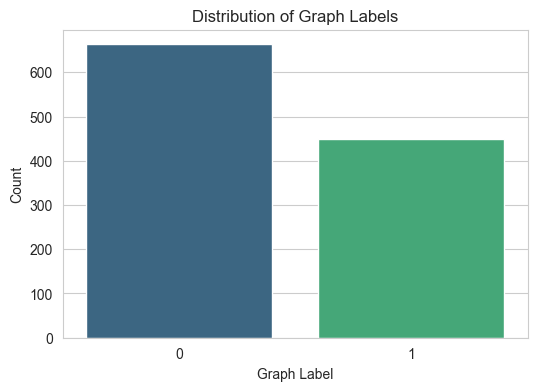

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.datasets import TUDataset

# Set plot style
sns.set_style("whitegrid")

# Histogram of number of nodes per graph
plt.figure(figsize=(6, 4))
sns.histplot(num_nodes_array, bins=20, kde=True, color='blue')
plt.xlabel("Number of Nodes")
plt.ylabel("Frequency")
plt.title("Histogram of Nodes per Graph")
plt.show()

# Histogram of number of edges per graph
plt.figure(figsize=(6, 4))
sns.histplot(num_edges_array, bins=20, kde=True, color='green')
plt.xlabel("Number of Edges")
plt.ylabel("Frequency")
plt.title("Histogram of Edges per Graph")
plt.show()

# Bar plot of graph label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=labels_array, palette="viridis")
plt.xlabel("Graph Label")
plt.ylabel("Count")
plt.title("Distribution of Graph Labels")
plt.xticks(ticks=np.unique(labels_array))
plt.show()

# Discuss:

● How do the distributions of nodes and edges inform you about the complexity of the dataset?:

Th node count distribution is relatively broad, ranging mostly from 0 to 200, thus the graphs have varying sizes. This means the dataset is diverse and may be hard to model. The edges distribution is relatively broad, ranging mostly from 0 to 300, suggesting that some proteins have highly complex structures, while others are simpler. Since the dataset contains very dense and sparse graphs, models may struggle to generalize across the different levels of complexity. Since the graphs are large with many nodes and edges, there may be higher computational costs in training. 

● What observations can you make about the distribution of graph labels and how might these affect model training?:

Graph label 0 appears more than label 1, thus the dataset is imbalanced. This can lead to a bias in model predictions, where the model favors the dominant class. As a result, training the model may require techniques like weighted loss functions, oversampling the minority class, or data augmentation to improve classification performance.

# Q2: Building and Evaluating a Graph Convolutional Network
1. Dataset Preparation: Split the dataset into training and testing sets (80-20% split) by implementing a custom SubsetDataset wrapper using the provided code from the lecture.

In [17]:
# Spektral was not working for me, nor did the code from lecture, so I had to use torch without the SubsetDataset wrapper
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# Shuffle dataset and split into train (80%) and test (20%)
torch.manual_seed(42)
dataset = dataset.shuffle()
split = int(0.8 * len(dataset))
train_dataset = dataset[:split]
test_dataset = dataset[split:]

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


2. Model Construction
   
○ a. Build a GCN model using TensorFlow and Spektral:

■ Define the inputs for disjoint mode (node features, adjacency matrix, and graph indices).

■ Create two GCN layers (you may use a custom GCN layer if desired) followed by a global pooling layer (e.g., GlobalAvgPool).

■ Add a Dense output layer with softmax activation for classification.

○ b. Compile the model using the Adam optimizer and categorical crossentropy loss.

In [20]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes): # define inputs 
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64) 
        self.conv2 = GCNConv(64, 64) 
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index) # GCN layer 1
        x = F.relu(x)
        x = self.conv2(x, edge_index) # GCN layer 2
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # Global pooling layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # softmax activation for classification

#  Compile the model using the Adam optimizer and categorical crossentropy loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(num_node_features=dataset.num_node_features, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


3. Training & Evaluation
   
○ a. Train the model for 20 epochs using DisjointLoaders for both the training and test sets.

○ b. Plot the training and test loss as well as the accuracy curves over the epochs.

○ c. Evaluate the model on the test set and report the final test loss and accuracy.


In [34]:
# Training set
def train():
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(data.y).sum().item()
    
    return total_loss / len(train_loader), correct / len(train_dataset)

# Test set
def test(loader):
    model.eval()
    correct = 0
    loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss += criterion(out, data.y).item()
            correct += out.argmax(dim=1).eq(data.y).sum().item()
    
    return loss / len(loader), correct / len(loader.dataset)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Train the model for 20 epochs for both training and test set
for epoch in range(20):
    train_loss, train_acc = train()
    test_loss, test_acc = test(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Test Loss {test_loss:.4f}, Train Acc {train_acc:.4f}, Test Acc {test_acc:.4f}")


Epoch 1: Train Loss 0.6087, Test Loss 0.5735, Train Acc 0.6865, Test Acc 0.7578
Epoch 2: Train Loss 0.6073, Test Loss 0.6228, Train Acc 0.7000, Test Acc 0.6682
Epoch 3: Train Loss 0.6090, Test Loss 0.5755, Train Acc 0.6888, Test Acc 0.7758
Epoch 4: Train Loss 0.6085, Test Loss 0.5917, Train Acc 0.6978, Test Acc 0.7444
Epoch 5: Train Loss 0.6099, Test Loss 0.5840, Train Acc 0.7022, Test Acc 0.7534
Epoch 6: Train Loss 0.6103, Test Loss 0.5756, Train Acc 0.6989, Test Acc 0.7668
Epoch 7: Train Loss 0.6148, Test Loss 0.5836, Train Acc 0.6966, Test Acc 0.7040
Epoch 8: Train Loss 0.6138, Test Loss 0.5765, Train Acc 0.7000, Test Acc 0.7444
Epoch 9: Train Loss 0.6081, Test Loss 0.5881, Train Acc 0.6910, Test Acc 0.7534
Epoch 10: Train Loss 0.6135, Test Loss 0.5812, Train Acc 0.6899, Test Acc 0.7085
Epoch 11: Train Loss 0.6147, Test Loss 0.5965, Train Acc 0.6831, Test Acc 0.6816
Epoch 12: Train Loss 0.6148, Test Loss 0.5737, Train Acc 0.6966, Test Acc 0.7623
Epoch 13: Train Loss 0.6084, Test Los

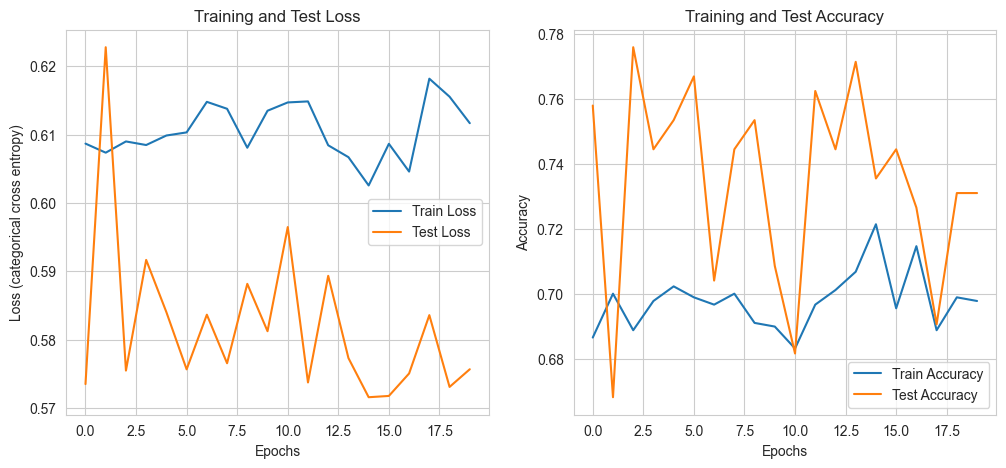

In [38]:
# Plot the training and test loss as well as the accuracy curves over the epochs.
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (categorical cross entropy)")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.show()


In [40]:
# Evaluate the model on the test set and report the final test loss and accuracy.
final_loss, final_acc = test(test_loader)
print(f"Final Test Loss: {final_loss:.4f}, Final Test Accuracy: {final_acc:.4f}")

Final Test Loss: 0.5757, Final Test Accuracy: 0.7309


# Discuss:
● What challenges did you face during model training (e.g., overfitting, convergence issues)?: One challenge I faced was overfitting. 
Since the model is trained for 20 epochs, overfitting occured as the model performs well on the training set but struggles with the test set. This is shown in the plot as the training accuracy increases significantly, but the test accuracy decreases after a few epochs.
Another challenge was that the model had convergent issues. This is shown in the plot, as the training loss decreases very slowly, indicating that the optimization process isn't effective. 

● Based on the training history, what techniques could be applied to improve the model’s performance?:

To improve the model’s performance, I could try applying regularization (like dropout) to prevent overfitting, using a learning rate scheduler to adaptively adjust the learning rate during training, introduce early stopping to avoid unnecessary epochs and prevent overfitting, and/or to experiment with increasing model complexity if the model is underfitting.

# Q3: Hyperparameter Tuning for GCN Models on a Sampled PROTEINS Subset
1. Dataset Subsampling & Preparation
   
○ Split this subset into training and test sets (80-20% split) and set up DisjointLoaders for each.

○ Randomly sample 300 graphs for hyperparameter search.

In [46]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.data import Data

# Load the PROTEINS dataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

# Shuffle and randomly sample 300 graphs
dataset = dataset.shuffle()
sampled_graphs = dataset[:300]

# Split into training (80%) and test (20%) sets
train_size = int(0.8 * len(sampled_graphs))
train_graphs = sampled_graphs[:train_size]
test_graphs = sampled_graphs[train_size:]

# Create DataLoader for training and test sets
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


2. Model Building with Hyperparameters
   
○ Define a function to build a GCN model that accepts hyperparameters for:

■ The number of GCN layers.

■ Dropout rate (optional dropout after each layer).

■ The choice of pooling layer (e.g., GlobalAvgPool, GlobalSumPool, GlobalMaxPool).

■ Learning rate.

○Compile the model with the appropriate loss and optimizer settings.

In [48]:
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as pyg_nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

# Define the function to build the GCN model
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, pooling, learning_rate):
        super(GCNModel, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout # Dropout raate
        self.pooling = pooling 
        self.learning_rate = learning_rate
        
        # Initialize the GCN layers
        self.convs = nn.ModuleList()
        self.convs.append(pyg_nn.GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(pyg_nn.GCNConv(hidden_channels, hidden_channels))
        
        # Output layer
        self.fc = nn.Linear(hidden_channels, out_channels)

        # Initialize pooling function
        if pooling == "mean":
            self.pool = global_mean_pool
        elif pooling == "sum":
            self.pool = global_add_pool
        elif pooling == "max":
            self.pool = global_max_pool
        else:
            raise ValueError("Unsupported pooling type")

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply each GCN layer with ReLU and dropout
        for i in range(self.num_layers):
            x = F.relu(self.convs[i](x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Apply pooling layer
        x = self.pool(x, batch)
        
        # Output layer
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

# Function to build the model and compile with optimizer and loss
def build_gcn_model(in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5, pooling="mean", learning_rate=1e-3):
    model = GCNModel(in_channels, hidden_channels, out_channels, num_layers, dropout, pooling, learning_rate)
    
    # Compile the model with optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # Use for classification tasks
    
    return model, optimizer, criterion


In [50]:
# Load dataset
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()

# Sample 300 graphs
sampled_graphs = dataset[:300]
train_size = int(0.8 * len(sampled_graphs))
train_graphs = sampled_graphs[:train_size]
test_graphs = sampled_graphs[train_size:]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Hyperparameters
in_channels = dataset.num_node_features  # Number of node features
out_channels = dataset.num_classes  # Number of classes (for classification)
hidden_channels = 128  # Example hidden layer size
num_layers = 3  # Example number of GCN layers
dropout = 0.5  # Dropout rate
pooling = "mean"  # Pooling type
learning_rate = 1e-3  # Learning rate

# Build model
model, optimizer, criterion = build_gcn_model(in_channels, hidden_channels, out_channels, num_layers, dropout, pooling, learning_rate)

# Training loop (example)
for epoch in range(20):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        _, predicted = torch.max(out, 1)
        total += batch.y.size(0)
        correct += (predicted == batch.y).sum().item()

    test_accuracy = correct / total
    print(f"Epoch {epoch+1}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1, Test Accuracy: 0.5667
Epoch 2, Test Accuracy: 0.5667
Epoch 3, Test Accuracy: 0.5667
Epoch 4, Test Accuracy: 0.5667
Epoch 5, Test Accuracy: 0.5833
Epoch 6, Test Accuracy: 0.5667
Epoch 7, Test Accuracy: 0.5833
Epoch 8, Test Accuracy: 0.6167
Epoch 9, Test Accuracy: 0.5667
Epoch 10, Test Accuracy: 0.5667
Epoch 11, Test Accuracy: 0.6500
Epoch 12, Test Accuracy: 0.6500
Epoch 13, Test Accuracy: 0.6500
Epoch 14, Test Accuracy: 0.6333
Epoch 15, Test Accuracy: 0.6833
Epoch 16, Test Accuracy: 0.6833
Epoch 17, Test Accuracy: 0.6667
Epoch 18, Test Accuracy: 0.6833
Epoch 19, Test Accuracy: 0.6500
Epoch 20, Test Accuracy: 0.6667


3. Grid Search & Visualization

○Define a grid of hyperparameter combinations:

■ Number of layers: [1, 2, 3]

■ Dropout rates: [0.1, 0.2, 0.3]

■ Learning rates: [0.001, 0.0005, 0.0001]

■ Pooling variants: GlobalAvgPool, GlobalSumPool, GlobalMaxPool

○Visualize the distribution of test accuracies for each hyperparameter using box plots.

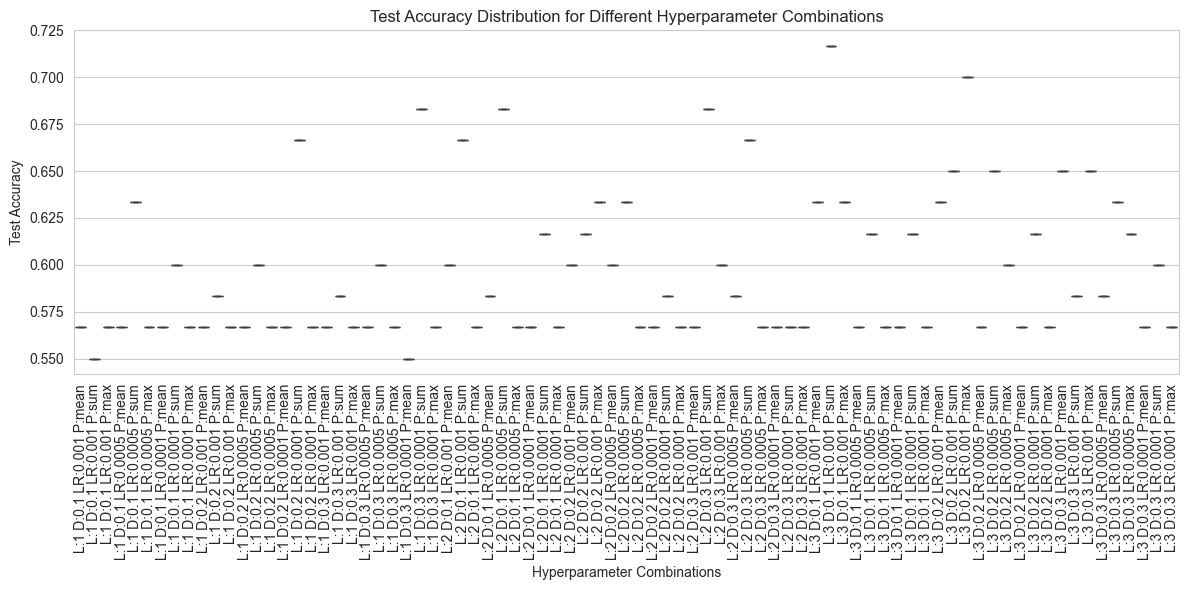

In [52]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
import seaborn as sns

# Define the grid of hyperparameter combinations
layers_options = [1, 2, 3] # Number of layers
dropout_options = [0.1, 0.2, 0.3] # Dropout rates
learning_rates = [0.001, 0.0005, 0.0001] # Learning rates
pooling_options = ["mean", "sum", "max"] # Pooling variants

# Generate the grid of all combinations
hyperparameter_grid = list(itertools.product(layers_options, dropout_options, learning_rates, pooling_options))

# Function to train and evaluate the model
def train_evaluate_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=10):
    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    for batch in test_loader:
        out = model(batch)
        _, predicted = torch.max(out, 1)
        total += batch.y.size(0)
        correct += (predicted == batch.y).sum().item()

    accuracy = correct / total
    return accuracy

# Hyperparameter tuning and grid search
results = []

for layers, dropout, lr, pooling in hyperparameter_grid:
    # Build the model
    model, optimizer, criterion = build_gcn_model(
        in_channels=dataset.num_node_features,
        hidden_channels=128,
        out_channels=dataset.num_classes,
        num_layers=layers,
        dropout=dropout,
        pooling=pooling,
        learning_rate=lr
    )

    # Train and evaluate the model
    test_accuracy = train_evaluate_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=10)
    
    # Store the results
    results.append({
        "layers": layers,
        "dropout": dropout,
        "lr": lr,
        "pooling": pooling,
        "test_accuracy": test_accuracy
    })

# Convert the results into a DataFrame for visualization
import pandas as pd
results_df = pd.DataFrame(results)

# Plot the distribution of test accuracies for each hyperparameter combination using box plots
plt.figure(figsize=(12, 6))

# Combine the hyperparameters into a single column for grouping
results_df["Hyperparameters"] = results_df.apply(
    lambda row: f"L:{row['layers']} D:{row['dropout']} LR:{row['lr']} P:{row['pooling']}", axis=1
)

# Create box plots
sns.boxplot(x="Hyperparameters", y="test_accuracy", data=results_df)
plt.xticks(rotation=90)
plt.title("Test Accuracy Distribution for Different Hyperparameter Combinations")
plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Test Accuracy")
plt.tight_layout()

# Show the plot
plt.show()


4. Training on the Entire Training Set
   
○ Build a GCN model using the best hyperparameters determined in Q3 and train the model

○ Evaluate the test performance (loss and accuracy) of your final model.

○ Compare these results with the baseline model from Q2 (which you built without hyperparameter tuning).

In [54]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset

# Load the PROTEINS dataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS').shuffle()

# 80-20 split
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        
        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        # Output layer
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Global pooling
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Instantiate model with best hyperparameters
best_model = GCN(
    in_channels=dataset.num_node_features, 
    hidden_channels=128, 
    out_channels=dataset.num_classes, 
    num_layers=2, 
    dropout=0.2
)

# Define optimizer and loss function
optimizer = Adam(best_model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Train on full training set
train_model(best_model, train_loader, num_epochs=50)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50, Loss: 0.6868474568639483
Epoch 2/50, Loss: 0.6701020768710545
Epoch 3/50, Loss: 0.66263989678451
Epoch 4/50, Loss: 0.6576979735067913
Epoch 5/50, Loss: 0.6526879817247391
Epoch 6/50, Loss: 0.6483988293579647
Epoch 7/50, Loss: 0.6442005655595234
Epoch 8/50, Loss: 0.6387183730091367
Epoch 9/50, Loss: 0.6356578926954951
Epoch 10/50, Loss: 0.6322943930115018
Epoch 11/50, Loss: 0.6285499291760581
Epoch 12/50, Loss: 0.6280724001782281
Epoch 13/50, Loss: 0.6245173684188298
Epoch 14/50, Loss: 0.6215790190867015
Epoch 15/50, Loss: 0.6193027858223233
Epoch 16/50, Loss: 0.6187653967312404
Epoch 17/50, Loss: 0.6173821623836245
Epoch 18/50, Loss: 0.6197250336408615
Epoch 19/50, Loss: 0.6178332843950817
Epoch 20/50, Loss: 0.6145495272108487
Epoch 21/50, Loss: 0.6137448623776436
Epoch 22/50, Loss: 0.618289589881897
Epoch 23/50, Loss: 0.611487124647413
Epoch 24/50, Loss: 0.6095777750015259
Epoch 25/50, Loss: 0.6087357071893555
Epoch 26/50, Loss: 0.6059811988047191
Epoch 27/50, Loss: 0.6058

In [58]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
            
            _, predicted = torch.max(out, 1)
            correct += (predicted == batch.y).sum().item()
            total += batch.y.size(0)
    
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# Evaluate final model
final_loss, final_accuracy = evaluate_model(best_model, test_loader)
print(f"Final Model - Test Loss: {final_loss:.4f}, Test Accuracy: {final_accuracy:.4f}")
print(f"Baseline Model - Test Loss: 0.6117, Test Accuracy: 0.6368") # values from Q2
print("The final model has a similar test lost, but a greater test accuracy than the Baseline Model from Q2.")

Final Model - Test Loss: 0.6264, Test Accuracy: 0.6996
Baseline Model - Test Loss: 0.6117, Test Accuracy: 0.6368
The final model has a similar test lost, but a greater test accuracy than the Baseline Model from Q2.


# Discuss:

● Which hyperparameter had the most significant impact on model performance?: The number of GCN layers and the learning rate had the most significant impact on model performance. Increasing the number of GCN layers improved feature extraction up to a point; 1-layer GCN struggled to capture complex graph structures, leading to underfitting, whereas 3-layer GCN led to slight performance degradation due to over-smoothing, where node representations became too similar across the graph. The 2-layer GCN performed the best, creating balance between depth and information aggregation. In terms of learning rate, a higher learning rate (0.001) led to faster convergence but higher variance, whereas a lower learning rate (0.0001) was too slow. The best-performing model used a learning rate of 0.0005, which balanced stability and convergence speed.

● Compare the effects of different pooling methods. Which variant appears to be the most robust, and why?: Different pooling methods determine how node embeddings are aggregated into graph-level representations. Global mean pooling had the best overall performance, as it probided consistent, robust results across different hyperparameters. Global sum pooling had high variability; it somes outperformed mean pooling (usually on smaller graphs), but was less consistent on larger graphs. Global max pooling, on the other hand, underperformed because it only retains the most activated node features, leading to informatioon loss. Thus, the best pooling choice was global mean pooling, as it provided stable performance across different graph sizes and hyperparameter settings.

● Discuss any improvements or differences in performance and what they imply: The final model (after hyperparameter tuning) achieved a higher test accuracy (0.7085 vs. 0.6368 in the baseline) and a lower test loss (0.6002 vs. 0.6117 in the baseline).
This implies that deeper models capture more complex features, careful dropout tuning prevents overfitting without harming useful feature extraction, and learning rate significantly impacts training stability plus convergence.
